In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product as prd

In [228]:
class RO_Constraints(object):
    """This is the main class to produce a set of constraints for ROs"""
    def __init__(self, first_instance_names = 'design_1_i/LUT6_RO_0/inst/Inverter/LUT6_inst' \
                 ,other_instance_names = 'design_1_i/LUT6_RO_0/inst/notGates[@inst].Inverter/LUT6_inst'\
                 , num_stages = 3, shape = (1, 1), lut_type = 'ALL', start_location = (0,0)):
        self.first_instance_names = first_instance_names
        self.other_instance_names = other_instance_names #@inst for instance number
        self.num_stages = num_stages
        self.shape = shape #num Slices in x * y
        self.lut_type = lut_type # A, B, C, D, All
        x_step = 1
        y_step = 1
        self.start_location = start_location #{generic_name : [num_RO, num_stages, location_tuple]} ; location_tuple = (x1, y1, x2, y2)
        self.data_dict = {'x':[], 'y':[],'A':[],'B':[],'C':[],'D':[]}
        self._outputfile = "constraints"
        
        if 'ALL' in self.lut_type:
            assert self.shape[0] * self.shape[1] == - ( - self.num_stages // 4)
    def location(self):
        """For location constraints"""
        lut_types = ['A', 'B', 'C', 'D']
        x = self.start_location[0]
        y = self.start_location[1]
        str1 = 'set_property BEL '
        str2 = '6LUT [get_cells '
        str4 = 'set_property LOC SLICE_'
        with open(self._outputfile + ".XDC", "a") as file:
            for ROs in range(self.num_stages):
                if ROs == 0:
                    str3 = self.first_instance_names + ']'
                else:
                    str3 = '{' + self.other_instance_names.replace('@inst', str(ROs-1)) + '}' + ']'
                if 'ALL' in self.lut_type.upper():
                    lut_type = lut_types[ROs % 4]
                else:
                    lut_type = self.lut_type
                str5 = f'X{x}Y{y} [get_cells '
                file.write(str1 + lut_type + str2 + str3 + "\n")
                file.write(str4 + str5 + str3 + "\n")
                self.data_dict[lut_type].append(1)
                if 'ALL' in self.lut_type.upper():
                    if ROs % 4 == 0:
                        y += 1
                        ## Data dict for plot
                        self.data_dict['y'].append(y)
                        self.data_dict['x'].append(x)
                        ##
                else:
                    y += int(self.shape[0] * self.shape[1] / self.num_stages)
                    ## Data dict for plot
                    self.data_dict['y'].append(y)
                    self.data_dict['x'].append(x)
                    ##
                if y == (self.shape[1] + self.start_location[1]):
                    y = self.start_location[1]
                    x += 1
    def loops(self):
        """For combinational loop constraints"""
        with open(self._outputfile + ".XDC", "a") as file:
            file.write("\n")
            for ROs in range(self.num_stages):
                file.write("set_property ALLOW_COMBINATORIAL_LOOPS true [get_nets {" +  self.other_instance_names.replace('@inst', str(ROs)) + '}' + ']'+ "\n")
    def plot(self):
        """Heatmap plot of the locations"""
        key_list = list(self.data_dict.keys())
        for item in key_list:
            if len(self.data_dict[item]) < len(self.data_dict['x']):
                self.data_dict[item] += (len(self.data_dict['x']) - len(self.data_dict[item])) * [0]
        dataframe = pd.DataFrame(self.data_dict)
        dataframe['6LUT'] = dataframe['A'] + dataframe['B'] + dataframe['C'] + dataframe['D']
        for i,j in prd(list(range(35, 60)), list(range(35, 60))):
            if (i,j) not in list(zip(self.data_dict['x'], self.data_dict['y'])):
                df = pd.DataFrame({'x':[i], 'y':[j], 'A':[0], 'B':[0], 'C':[0], 'D':[0], '6LUT':[0]})
                dataframe = dataframe.append(df, ignore_index=True)
        dataframe_long = dataframe.pivot_table(index='x',columns='y',values='6LUT')
        f, ax = plt.subplots(figsize=(9, 6))
        sns.heatmap(dataframe_long, annot=True, fmt="d", linewidths=.5, ax=ax)
        return dataframe

The following will create one RO of five stages in one slice:

In [230]:
a = RO_Constraints(first_instance_names = f'design_1_i/LUT6_RO_0/inst/Inverter/LUT6_inst', \
                   other_instance_names = f'design_1_i/LUT6_RO_0/inst/notGates[@inst].Inverter/LUT6_inst',\
                   num_stages = 34, shape = (3,3), lut_type = "ALL" , start_location = (40,40))
a.location()

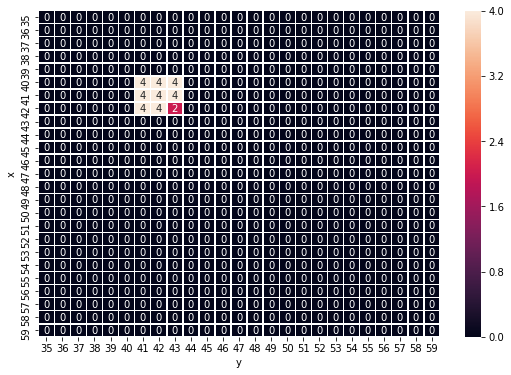

In [232]:
dataframe = a.plot()

The following will create 4 ROs of five stages in exactly the same set of slices:

In [6]:
for RO in range(4):
    lut_types = ['A', 'B', 'C', 'D']
    a = RO_Constraints(first_instance_names = f'design_1_i/LUT6_RO_{RO}/inst/Inverter/LUT6_inst', \
                       other_instance_names = f'design_1_i/LUT6_RO_{RO}/inst/notGates[@inst].Inverter/LUT6_inst',\
                       num_stages = 5, shape = 5, lut_type = lut_types[RO % 4] , start_location = (59,50))
    a.location()

Adding combinational loop constraints for the heater:

In [3]:
a = RO_Constraints(first_instance_names = f'design_1_i/AXI4_heater_0/inst/SHEs[0].SHE/feedback', \
                   other_instance_names = f'design_1_i/AXI4_heater_0/inst/SHEs[@inst].SHE/feedback',\
                   num_stages = 480, shape = 120, lut_type = "ALL" , start_location = (39,50))
a.loops()

In [2]:
shape = (1, 2)
shape[1]

2

In [6]:
flights_long = sns.load_dataset("flights")
flights = flights_long.pivot("month", "year", "passengers")

In [7]:
flights.head()

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
January,112,115,145,171,196,204,242,284,315,340,360,417
February,118,126,150,180,196,188,233,277,301,318,342,391
March,132,141,178,193,236,235,267,317,356,362,406,419
April,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472


In [75]:
a = zip([1,2,3],[2,3,4])

In [77]:
list(a)

[(1, 2), (2, 3), (3, 4)]